<a href="https://colab.research.google.com/github/Basado0/Basado0/blob/main/10_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.23.5
!pip install scikit-surprise==1.1.3

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-linux_x86_64.whl size=3310816 sha256=abe76887fc84d86ad7e78e2efe1d8b1d486f464cd03d5745d5182b29b7d787c7
  Stored in directory: /root/.cache/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [3]:
# 1. Загрузка данных
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Beauty.csv"
df = pd.read_csv(url, header=None, names=['user_id', 'product_id', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)


In [5]:
# 2. Предобработка данных
print(f"Исходный размер датасета: {df.shape}")
# Фильтрация редких пользователей и товаров
min_user_ratings = 5
min_product_ratings = 10
user_counts = df['user_id'].value_counts()
product_counts = df['product_id'].value_counts()

df = df[df['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)]
df = df[df['product_id'].isin(product_counts[product_counts >= min_product_ratings].index)]
print(f"Размер после фильтрации: {df.shape}\n")



Исходный размер датасета: (2023070, 3)
Размер после фильтрации: (350229, 3)



/tmp/ipython-input-10-1105966043.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')
/tmp/ipython-input-10-1105966043.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.values, x=top_products.index, palette='rocket')


Text(0, 0.5, 'Частота')

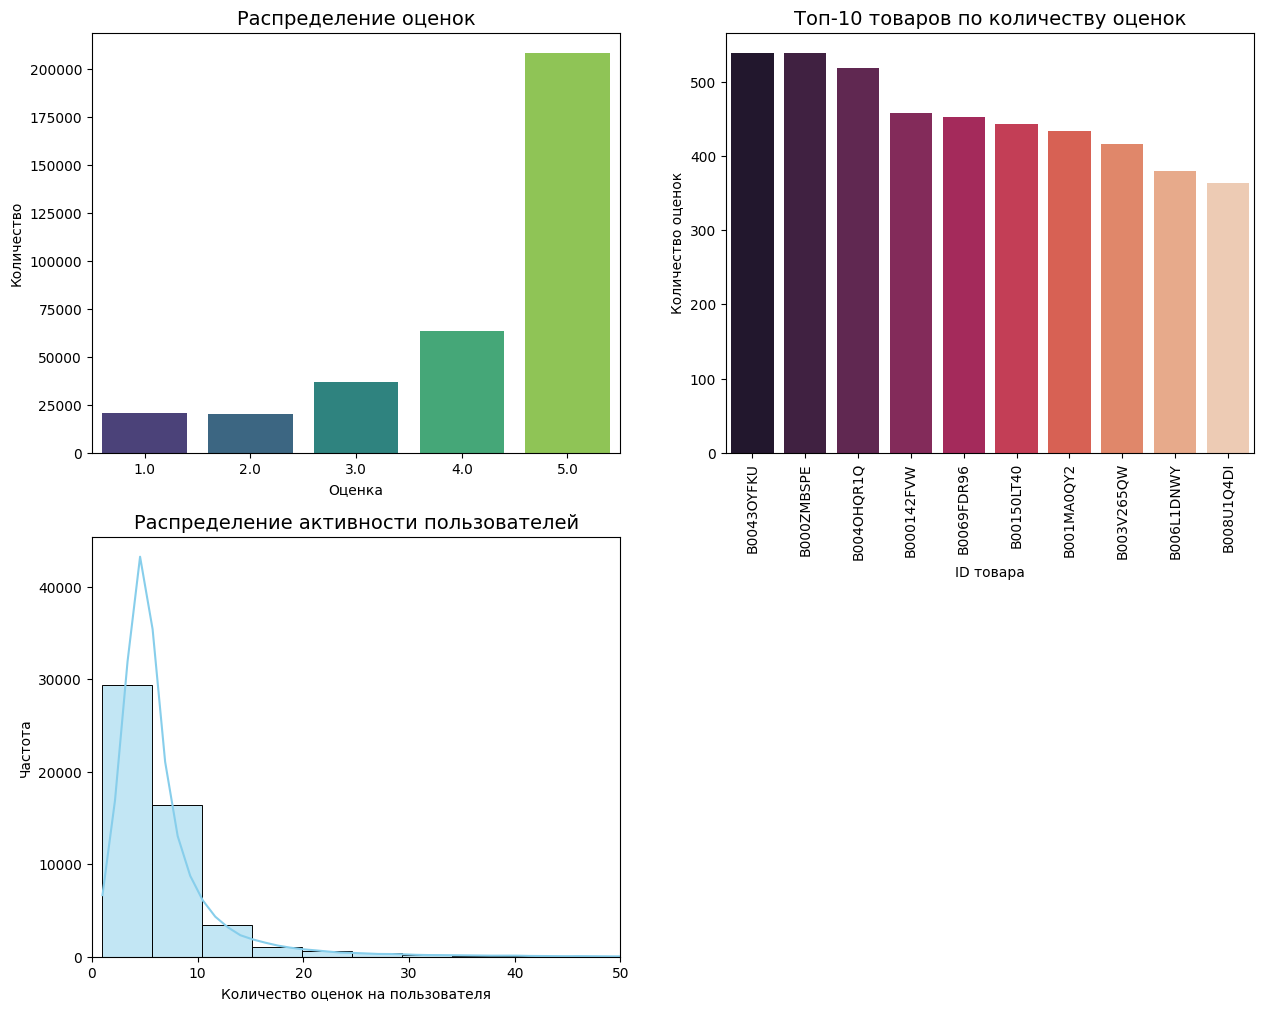

In [10]:
# 3. Визуализация данных
plt.figure(figsize=(15, 12))

# Распределение рейтингов
plt.subplot(2, 2, 1)
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Распределение оценок', fontsize=14)
plt.xlabel('Оценка')
plt.ylabel('Количество')

# Топ-10 популярных товаров
plt.subplot(2, 2, 2)
top_products = df['product_id'].value_counts().head(10)
sns.barplot(y=top_products.values, x=top_products.index, palette='rocket')
plt.title('Топ-10 товаров по количеству оценок', fontsize=14)
plt.xlabel('ID товара')
plt.ylabel('Количество оценок')
plt.xticks(rotation=90)
# Распределение активности пользователей
plt.subplot(2, 2, 3)
user_activity = df['user_id'].value_counts()
sns.histplot(user_activity, bins=50, kde=True, color='skyblue')
plt.xlim(0, 50)
plt.title('Распределение активности пользователей', fontsize=14)
plt.xlabel('Количество оценок на пользователя')
plt.ylabel('Частота')




In [11]:
# 4. Построение модели рекомендаций
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'product_id', 'rating']], reader)

# Разделение данных
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Обучение модели
model = SVD(n_factors=100,
            n_epochs=30,
            lr_all=0.005,
            reg_all=0.1,
            random_state=42)
model.fit(trainset)

In [12]:
# 5. Оценка модели
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"\nИтоговые метрики:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 1.1205
MAE:  0.8617

Итоговые метрики:
RMSE: 1.1205
MAE: 0.8617


In [13]:
# 6. Пример рекомендаций
def get_recommendations(user_id, n=5):
    """Генерация рекомендаций для указанного пользователя"""
    try:
        # Все товары в датасете
        all_items = df['product_id'].unique()

        # Товары, которые пользователь уже оценивал
        rated_items = df[df['user_id'] == user_id]['product_id'].values

        # Предсказание рейтингов для неоцененных товаров
        predictions = []
        for item_id in all_items:
            if item_id not in rated_items:
                pred = model.predict(user_id, item_id)
                predictions.append((item_id, pred.est))

        # Сортировка по убыванию рейтинга
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]
    except:
        return None

In [19]:
# Пример для конкретного пользователя
sample_user = df['user_id'].sample(1).values[0]
recommendations = get_recommendations(sample_user, 5)

print(f"\nРекомендации для пользователя {sample_user}:")
if recommendations:
    for i, (item_id, rating) in enumerate(recommendations, 1):
        print(f"{i}. Товар: {item_id}, Прогнозируемый рейтинг: {rating:.2f}")
else:
    print("Пользователь не найден или недостаточно данных")


Рекомендации для пользователя A4857B2UWUP2K:
1. Товар: B00CP4QKT4, Прогнозируемый рейтинг: 4.87
2. Товар: B001KMR9WY, Прогнозируемый рейтинг: 4.85
3. Товар: B0002Z8QHW, Прогнозируемый рейтинг: 4.85
4. Товар: B003IXP6P0, Прогнозируемый рейтинг: 4.82
5. Товар: B004ULUVU4, Прогнозируемый рейтинг: 4.81
